In [1]:
import os, sys
import numpy as np
import torch
sys.path.append('script')
from Synthesis import init_LocalTransform, predict_product

dataset = 'USPTO_480k' # get the info of derived templates
scenario = 'mix' # 'sep' or 'mix'

model_name = 'LocalTransform_%s' % scenario
device = torch.device('cuda:0')
model_path = 'models/%s.pth' % model_name
config_path = 'data/configs/default_config'
data_dir = 'data/%s' % dataset

args = {'data_dir': data_dir, 'model_path': model_path, 'config_path': config_path, 'device': device, 'mode': 'test'}
model, graph_functions, template_dicts, template_infos = init_LocalTransform(args)
model_parameters = filter(lambda p: p.requires_grad, model.parameters())
params = sum([np.prod(p.size()) for p in model_parameters])
print ('# model parameters: %.2fM' % (params/1000000))

Using backend: pytorch


Parameters of loaded LocalTransform:
{'attention_heads': 8, 'attention_layers': 3, 'edge_hidden_feats': 32, 'node_out_feats': 256, 'num_step_message_passing': 3, 'Template_rn': 4540, 'Template_vn': 2635, 'in_node_feats': 80, 'in_edge_feats': 13}
loaded 4540 real templates
loaded 2635 virtual templates
# model parameters: 13.49M


0th prediction: [A:1].[A:2]-[A:3]>>[A:1]-[A:2] A [7, 18] 0.96175116 -10 00
1th prediction: [A:1].[A:2]-[A:3]>>[A:1]-[A:2] B [18, 19] 0.9193174 -10 00
2th prediction: [A:1].[A:2]-[A:3]>>[A:1]-[A:2] B [15, 16] 0.15873457 -10 00
3th prediction: [A:1].[A:2]-[A:3]>>[A:1]-[A:2] A [7, 15] 0.10370193 -10 00
4th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] B [6, 7] 0.002759918 00 00
5th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] A [18, 7] 0.002569151 00 00
6th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] B [18, 19] 0.0021367567 00 00
7th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] A [15, 7] 0.0008887323 00 00
8th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] A [7, 18] 0.00072649453 00 00
9th prediction: [A:1]-[A:2]>>[A:1] B [6, 7] 0.00063602644 1 0
10th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] A [18, 6] 0.00032851167 00 00
11th prediction: [A:1]-[A:3].[A:2]-[A:4]>>[A:1]-[A:2] A [6, 18] 0.00014784368 00 00
12th prediction: [A:1]-[A:2]>>[A:1] B [18, 19] 0.00010303743

,SMILES,Edition,Score,Molecule
0,N#Cc1ccsc1N.O=[N+]([O-])c1cc(F)c(F)cc1F.C1CCOC...,None,NaN,
1,N#Cc1ccsc1Nc1cc(F)c(F)cc1[N+](=O)[O-],{'template': '([N:1]).([c:2]-[F:3])>>([N:1]-[c...,0.940534,
2,N#Cc1ccsc1Nc1cc(F)c([N+](=O)[O-])cc1F,{'template': '([N:1]).([c:2]-[F:3])>>([N:1]-[c...,0.131218,
3,N#Cc1ccsc1-c1cc(F)c(F)cc1[N+](=O)[O-],{'template': '([c:2]-[N:4]).([c:1]-[F:3])>>([c...,0.001343,
4,N#Cc1ccsc1,"{'template': '([c:1]-[N:2])>>([c:1])', 'pred_a...",0.000636,
5,O=[N+]([O-])c1ccc(F)c(F)c1,"{'template': '([c:1]-[F:2])>>([c:1])', 'pred_a...",0.000103,

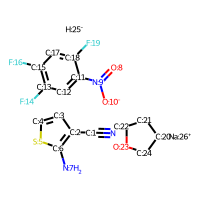
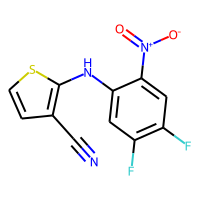
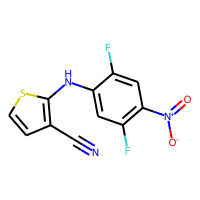
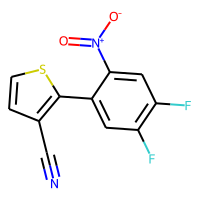
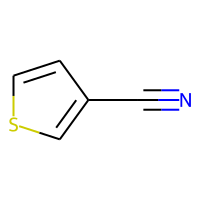
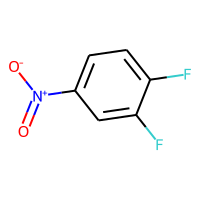

In [2]:
# Simple reaction outcome prediction
reactants = 'N#Cc1ccsc1N.O=[N+]([O-])c1cc(F)c(F)cc1F.C1CCOC1.[H-].[Na+]'
sep = False
verbose = 1
results, attentions = predict_product(reactants, model, graph_functions, device, template_dicts, template_infos, verbose = verbose, sep = sep)
results

In [3]:
# Human benchmark
import pandas as pd
extra = 'data/Human_benchmark/human.csv'
extra = pd.read_csv(extra)
rxns = extra['Reaction smiles']

,SMILES,Edition,Score,Correct,Molecule
0,[C:27]([c:28]1[cH:29][cH:30][c:31]([OH:32])[c:...,None,NaN,None,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"
1,CC1(C)N=C(n2ccccc2=O)c2cc(C#N)ccc2O1,{'template': '([C:2]-[Cl:3]).([n:1])>>([n:1]-[...,0.876791,False,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>"

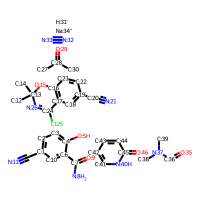
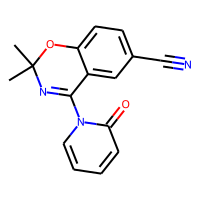

In [4]:
test_id = 68 # wrong_ids: 14, 44, 61, 68, 76
rxn = rxns[test_id-1]
reactants, product = rxn.split('>>')
results, attentions = predict_product(reactants, model, graph_functions, device, template_dicts, template_infos, product = product, top_k = 1, verbose = 0)
results